# This is the minimum Working Example to compute a multiple scattering experiment in the Q-Phase 

In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 10 19:53:32 2017

@author: Bene

This file creates a fwd-model for the TESCAN Q-PHASE under 
multiple-scattering. It is majorly derived from  "LEarning approach for optical tomography"
U. S. Kamilov, BIG, EPFL, 2014.
"""
# %load_ext autoreload
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from datetime import datetime

# load own functions
import src.model as mus
import src.tf_helper as tf_helper
import src.tf_generate_object as tf_go
import src.data as data
import src.optimization.tf_regularizers as reg


# change the following to %matplotlib notebook for interactive plotting
# %matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(8, 5))
mpl.rc('image', cmap='gray')


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


# Define some optimization parameters 

In [2]:
'''Define some stuff related to infrastructure'''
mytimestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
savepath = os.path.join('./Data/DROPLETS/RESULTS/', mytimestamp)

# Create directory
try: 
    os.mkdir(savepath)
except(FileExistsError): 
    print('Folder exists already')

# Define parameters 
is_padding = False 
is_display = True
is_optimization = True 
is_optimization_psf = False
is_flip = False
is_measurement = False

# data files for parameters and measuremets 
if is_measurement:
    matlab_val_file = './Data/DROPLETS/allAmp_red.mat'      #'./Data/DROPLETS/allAmp_simu.npy' #
    matlab_par_file = './Data/DROPLETS/myParameterNew.mat'   
    matlab_val_name = 'allAmp_red'
    matlab_par_name = 'myParameterNew'    
else:
    matlab_val_file = './Data/DROPLETS/RESULTS/allAmp_simu.npy' #'./Data/DROPLETS/allAmp_simu.mat'      
    matlab_par_file = './Data/DROPLETS/myParameterNew.mat' 
    matlab_val_name = 'allAmp_red'
    matlab_par_name = 'myParameterNew'

# microscope parameters
zernikefactors = np.array((0,0,0,0,0,0,0,0,0)) # representing the 9 first zernike coefficients in noll-writings 
dn = .075 # refractive index of the object (difference)
NAc = .52

'''Define Optimization Parameters'''
my_learningrate = 5e-3  # learning rate
lambda_tv =  1e-3 # lambda for Total variation
lambda_gr = 0 # lambda for Goods Roughness 
lambda_pos = 0
lambda_neg = 10

Niter = 1000
Ndisplay = 10


'''START CODE'''
tf.reset_default_graph() # just in case there was an open session

# Generate Test-Object

In [3]:
''' File which stores the experimental parameters from the Q-PHASE setup 
    1.) Read in the parameters of the dataset ''' 
matlab_pars = data.import_parameters_mat(filename = matlab_par_file, matname='myParameterNew')

''' 2.) Read in the parameters of the dataset ''' 
if(matlab_val_file.find('mat')==-1):
    matlab_val = np.load(matlab_val_file)
else:
    matlab_val = data.import_realdata_h5(filename = matlab_val_file, matname='allAmp_red', is_complex=True)

if(is_flip):
    np_meas_raw = np.flip(matlab_val,0)
    print('Attention: We are flipping the data!')
else:
    np_meas_raw = matlab_val
    print('do we need to flip the data?! -> Observe FFT!!')



''' Create the Model'''
muscat = mus.MuScatModel(matlab_pars, is_optimization=is_optimization, is_optimization_psf = is_optimization_psf)
muscat.Nx,muscat.Ny = int(np.squeeze(matlab_pars['Nx'].value)), int(np.squeeze(matlab_pars['Ny'].value))
muscat.shiftIcY=0
muscat.shiftIcX=0
muscat.dn = dn
muscat.NAc = NAc
muscat.dz = muscat.lambda0/4
print('Attention: Changed Z-sampling!!')

''' Adjust some parameters to fit it in the memory '''
muscat.mysize = (muscat.Nz,muscat.Nx,muscat.Ny) # ordering is (Nillu, Nz, Nx, Ny)

''' Create a 3D Refractive Index Distributaton as a artificial sample'''
obj = tf_go.generateObject(mysize=muscat.mysize, obj_dim=(muscat.dz,muscat.dx,muscat.dy), obj_type ='sphere', diameter = 1, dn = muscat.dn)

# introduce zernike factors here
muscat.zernikefactors = zernikefactors



do we need to flip the data?! -> Observe FFT!!
Assigned some value for dn which is not good!
Attention: Changed Z-sampling!!


# Compute the System's properties (e.g. Pupil function/Illumination Source, K-vectors, etc.)

In [4]:
''' Compute the systems model'''
muscat.computesys(obj, is_zernike=True, is_padding=is_padding, dropout_prob=1)
print(muscat.Ic.shape)

----------> Be aware: We are taking aberrations into account!
We are weighing the Intensity int the illu-pupil!
Shifting the illumination in X by: 0 Pixel
Shifting the illumination in Y by: 0 Pixel
Number of Illumination Angles / Plane waves: 49
(32, 32)


# Generate Computational Graph (fwd model)

Buildup Q-PHASE Model 


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:416: ComplexWarning: Casting complex values to real discards the imaginary part
  nparray = values.astype(dtype.as_numpy_dtype)


----------> Bringing back Field to focus


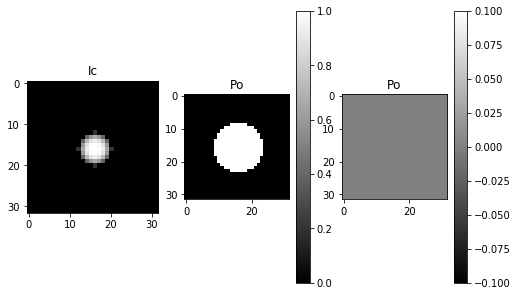

In [5]:
tf_fwd = muscat.computemodel()

if(is_display): 
    plt.subplot(131), plt.title('Ic'), plt.imshow(muscat.Ic)
    plt.subplot(132), plt.title('Po'),plt.imshow(np.fft.fftshift(np.abs(muscat.Po))), plt.colorbar()
    plt.subplot(133), plt.title('Po'),plt.imshow(np.fft.fftshift(np.angle(muscat.Po))), plt.colorbar(), plt.show()

# Define Optimizer and Cost-function

Now load data which has been saved previously (Optional!)

Evtl unwrap it!


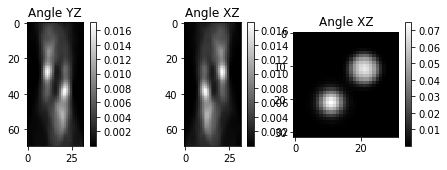

In [6]:
print('Evtl unwrap it!')

# this is the initial guess of the reconstruction
np_meas=np_meas_raw#*np.exp(1j*np.pi)

if(False):
    init_guess = np.angle(np_meas)
    init_guess = init_guess - np.min(init_guess)
    init_guess = init_guess**3
    init_guess = init_guess/np.max(init_guess)*muscat.dn
elif(True):
    init_guess = -np.abs(np_meas)
    init_guess = init_guess - np.min(init_guess)
    init_guess = init_guess**3
    init_guess = init_guess/np.max(init_guess)*muscat.dn
    init_guess = np.flip(init_guess,0)
else:
    init_guess = np.random.randn(init_guess.shape[0],init_guess.shape[1],init_guess.shape[2])*muscat.dn

        

if(is_display): plt.subplot(231), plt.title('Angle YZ'),plt.imshow(init_guess[:,init_guess.shape[1]//2,:]), plt.colorbar()
if(is_display): plt.subplot(232), plt.title('Angle XZ'),plt.imshow(init_guess[:,:,init_guess.shape[1]//2]), plt.colorbar()
if(is_display): plt.subplot(233), plt.title('Angle XZ'),plt.imshow(init_guess[init_guess.shape[0]//2,:,:]), plt.colorbar(),plt.show()


# Optimize

# Estimate the Phase difference between Measurement and Simulation

In [7]:
#%%
'''Regression + Regularization'''
tf_meas = tf.placeholder(dtype=tf.complex64, shape=init_guess.shape)
             
'''Define Cost-function'''
tf_tvloss = lambda_tv*reg.tf_total_variation_regularization(muscat.TF_obj_phase, BetaVals = [muscat.dx,muscat.dy,muscat.dz], epsR=.001)  #Alernatively tf_total_variation_regularization # total_variation
#tf_posloss = lambda_neg*reg.posiminity(muscat.TF_obj_phase, minval=0)
#tf_negloss = lambda_pos*reg.posimaxity(muscat.TF_obj_phase, maxval=.2) 
tf_negsqrloss = lambda_neg*reg.RegularizeNegSqr(muscat.TF_obj_phase)
tf_globalphase = tf.Variable(0., tf.float32, name='var_phase')
tf_globalabs = tf.Variable(1., tf.float32, name='var_abs')# 
tf_fidelity = tf.reduce_sum(tf_helper.tf_abssqr(tf_fwd  - (tf_meas/tf.cast(tf.abs(tf_globalabs), tf.complex64)*tf.exp(1j*tf.cast(tf_globalphase, tf.complex64))))) # allow a global phase parameter to avoid unwrapping effects
tf_loss = tf_fidelity +  tf_negsqrloss + tf_tvloss #tf_negloss + tf_posloss + tf_tvloss

 # data fidelity
# TV regularization
# Positivity Penalty          
# eventually Goods Roughness reg
          
if(True):          
    '''Define Optimizer'''
    tf_learningrate = tf.placeholder(tf.float32, []) 
    tf_optimizer = tf.train.AdamOptimizer(tf_learningrate)
    tf_lossop = tf_optimizer.minimize(tf_loss)
else:
    tf_optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss, options={'maxiter': 40},method='L-BFGS-B') # 'L-BFGS-B'
    tf_optimizer.minimize(sess)
    myloss=loss.eval()
    
''' Evaluate the model '''
sess = tf.Session()
sess.run(tf.global_variables_initializer())
if is_optimization:
    if is_padding:
        # Pad object with zeros along X/Y
        init_guess_tmp= np.zeros(muscat.mysize)# + 1j*np.zeros(muscat.mysize)
        init_guess_tmp[:,muscat.Nx//2-muscat.Nx//4:muscat.Nx//2+muscat.Nx//4, muscat.Ny//2-muscat.Ny//4:muscat.Ny//2+muscat.Ny//4] =init_guess
        init_guess = init_guess_tmp

    sess.run(tf.assign(muscat.TF_obj_phase, init_guess)); # assign abs of measurement as initial guess of 

my_fwd = sess.run(tf_fwd)#, feed_dict={muscat.TF_obj:obj})
mysize = my_fwd.shape



We use circular shift for the TV regularizer


My Init Phase is :-0.887768679857254


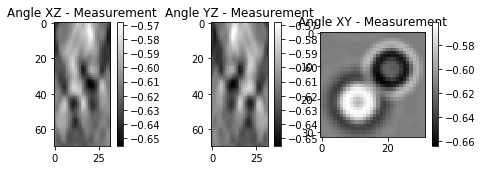

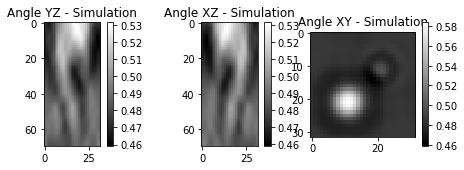

In [8]:
# We assume, that there is a global phase mismatch between measurment and first estimate of the fwd model, this can be estimated by the difference of mean phase of the two
# subtracting the mean phase from either measurement or the fwd model could help to speed up the optimization
# this is the initial guess of the reconstruction
np_meas = matlab_val
myinitphase = np.mean(np.angle(np_meas))-np.mean(np.angle(my_fwd))-.9
print('My Init Phase is :'+str(myinitphase))
np_meas=np_meas*np.exp(-1j*(myinitphase+2)) # subtract globaphase - anyway we want to optimize for that, but now the global phase can be assumed to be 0 initally
if(is_display): plt.subplot(231), plt.title('Angle XZ - Measurement'),plt.imshow(np.angle(np_meas)[:,mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(232), plt.title('Angle YZ - Measurement'),plt.imshow(np.angle(np_meas)[:,:,mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(233), plt.title('Angle XY - Measurement'),plt.imshow(np.angle(np_meas)[mysize[0]//2,:,:]), plt.colorbar(), plt.show()

if(is_display): plt.subplot(234), plt.title('Angle YZ - Simulation'),plt.imshow(np.angle(my_fwd)[:,mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235), plt.title('Angle XZ - Simulation'),plt.imshow(np.angle(my_fwd)[:,:,mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(236), plt.title('Angle XY - Simulation'),plt.imshow(np.angle(my_fwd)[mysize[0]//2,:,:]), plt.colorbar(), plt.show()

# assert some memory 
iter_last = 0
mylosslist = []
myfidelitylist = []
myposlosslist = []
myneglosslist = []
mytvlosslist = []
result_phaselist = []
result_reallist = []
globalphaselist = []
globalabslist = []

Start optimizing
Loss@0: 51.17341 - Fid: 46.016415, Neg: 0.0, TV: 5.1569943 G-Phase:-0.0049999994 G-ABS: 1.005


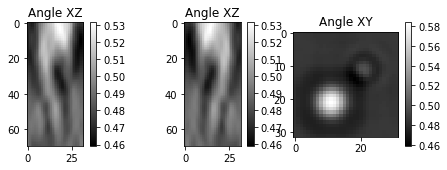

Loss@10: 327.0183 - Fid: 265.92438, Neg: 49.248657, TV: 11.845276 G-Phase:-0.002896849 G-ABS: 1.0520234


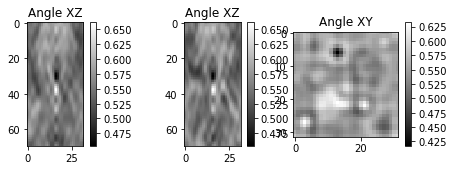

Loss@20: 160.93509 - Fid: 82.98442, Neg: 65.09488, TV: 12.855785 G-Phase:-0.0010958923 G-ABS: 1.0863107


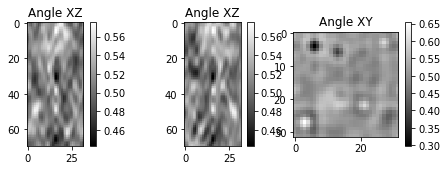

Loss@30: 90.52237 - Fid: 44.06047, Neg: 34.92935, TV: 11.532545 G-Phase:0.00063140166 G-ABS: 1.1048685


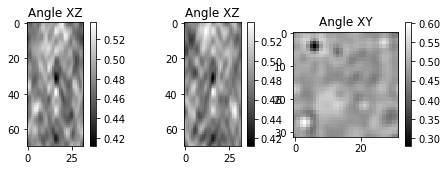

Loss@40: 42.599945 - Fid: 21.266987, Neg: 11.329466, TV: 10.003495 G-Phase:0.0010158246 G-ABS: 1.1129179


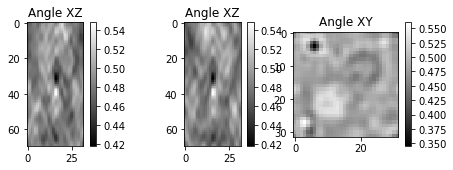

Loss@50: 20.36892 - Fid: 7.705508, Neg: 3.7476122, TV: 8.915798 G-Phase:0.0008421785 G-ABS: 1.116177


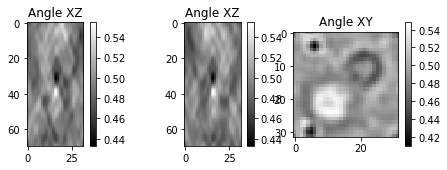

Loss@60: 13.746105 - Fid: 3.9303112, Neg: 1.6908648, TV: 8.124929 G-Phase:0.00073687336 G-ABS: 1.117209


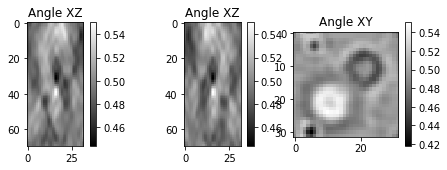

Loss@70: 11.040465 - Fid: 2.5690858, Neg: 0.98616034, TV: 7.485219 G-Phase:0.00071070925 G-ABS: 1.1173205


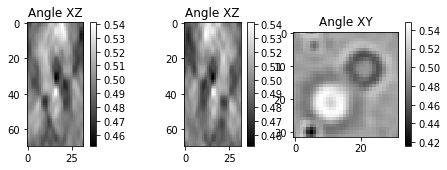

Loss@80: 9.626797 - Fid: 1.9454794, Neg: 0.6964617, TV: 6.984855 G-Phase:0.000692552 G-ABS: 1.1168936


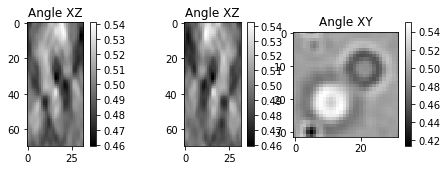

Loss@90: 8.692407 - Fid: 1.5638305, Neg: 0.53693503, TV: 6.591641 G-Phase:0.00065525813 G-ABS: 1.116295


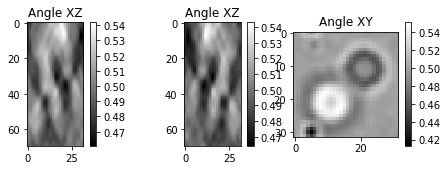

Loss@100: 8.070919 - Fid: 1.3322723, Neg: 0.43669856, TV: 6.3019485 G-Phase:0.0006205161 G-ABS: 1.115577


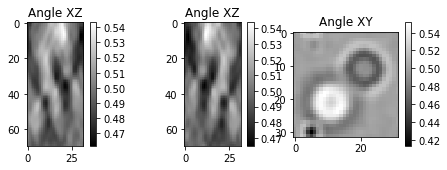

Loss@110: 7.7088385 - Fid: 1.257357, Neg: 0.36291495, TV: 6.088567 G-Phase:0.0006203632 G-ABS: 1.1147859


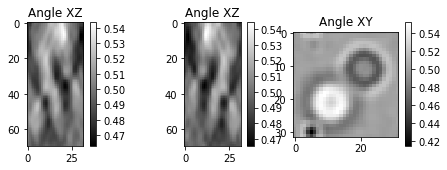

Loss@120: 15.92568 - Fid: 9.721253, Neg: 0.29064196, TV: 5.9137855 G-Phase:0.00063168164 G-ABS: 1.113843


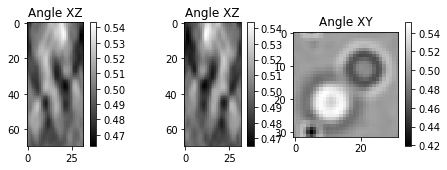

Loss@130: 10.540791 - Fid: 4.4601617, Neg: 0.26502666, TV: 5.815603 G-Phase:0.0006282706 G-ABS: 1.1134948


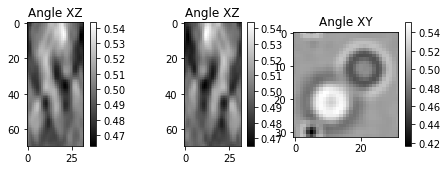

Loss@140: 7.405107 - Fid: 1.4152732, Neg: 0.24524555, TV: 5.7445884 G-Phase:0.00061774475 G-ABS: 1.1130409


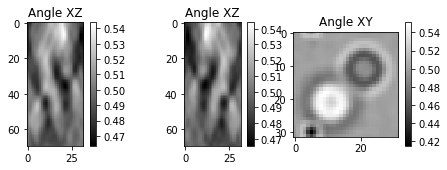

Loss@150: 6.9329276 - Fid: 1.0195864, Neg: 0.22746147, TV: 5.6858797 G-Phase:0.00061259425 G-ABS: 1.1123469


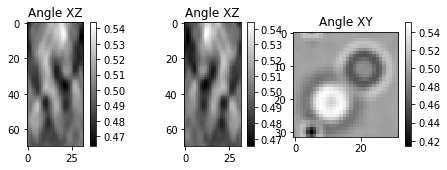

Loss@160: 6.866037 - Fid: 1.024057, Neg: 0.2083607, TV: 5.6336193 G-Phase:0.00060173176 G-ABS: 1.1115097


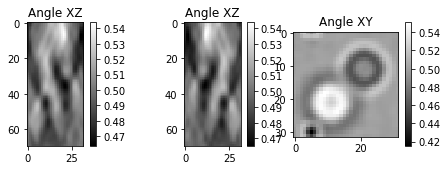

Loss@170: 6.8347135 - Fid: 1.0500023, Neg: 0.19184576, TV: 5.5928655 G-Phase:0.00059084245 G-ABS: 1.1106052


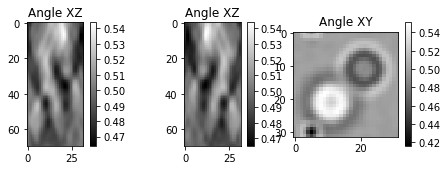

Loss@180: 6.720332 - Fid: 0.9741025, Neg: 0.18006831, TV: 5.5661616 G-Phase:0.00057957286 G-ABS: 1.1097192


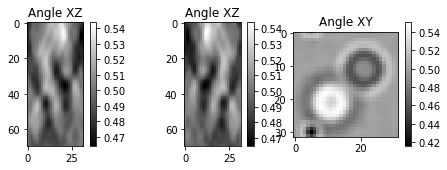

Loss@190: 7.571153 - Fid: 1.8521023, Neg: 0.17076448, TV: 5.5482864 G-Phase:0.0005668102 G-ABS: 1.1088394


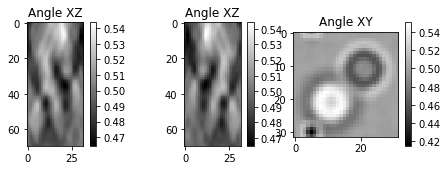

Loss@200: 6.570674 - Fid: 0.8936199, Neg: 0.15248285, TV: 5.524571 G-Phase:0.0005609178 G-ABS: 1.1081164


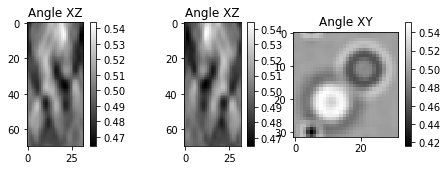

Loss@210: 8.215654 - Fid: 2.5449684, Neg: 0.14572838, TV: 5.524957 G-Phase:0.0005519346 G-ABS: 1.1077915


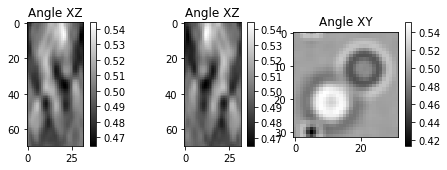

Loss@220: 7.211458 - Fid: 1.5702889, Neg: 0.13427919, TV: 5.50689 G-Phase:0.00053992396 G-ABS: 1.1071545


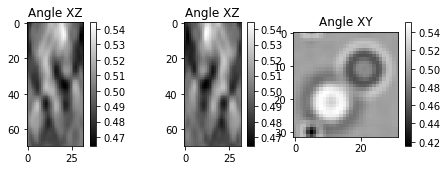

Loss@230: 6.7688093 - Fid: 1.1667914, Neg: 0.12128133, TV: 5.4807367 G-Phase:0.0005256017 G-ABS: 1.1062453


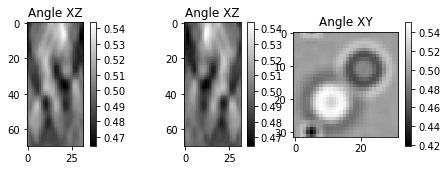

Loss@240: 6.6603384 - Fid: 1.0634713, Neg: 0.118512824, TV: 5.478354 G-Phase:0.0005112444 G-ABS: 1.1053915


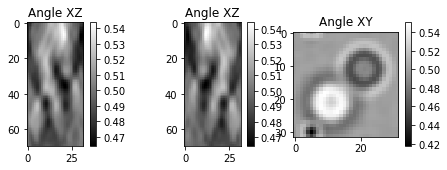

Loss@250: 6.3844647 - Fid: 0.81065476, Neg: 0.11023597, TV: 5.463574 G-Phase:0.00049570395 G-ABS: 1.1043975


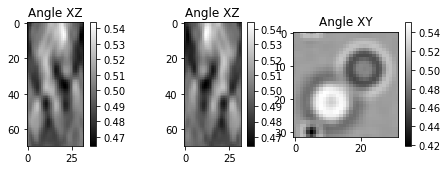

Loss@260: 6.902643 - Fid: 1.3526503, Neg: 0.10173477, TV: 5.448258 G-Phase:0.00047901075 G-ABS: 1.1033273


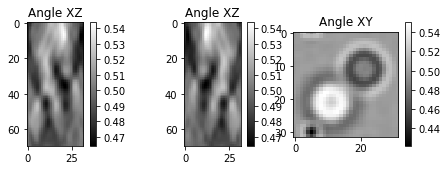

Loss@270: 6.520434 - Fid: 0.9599732, Neg: 0.09801158, TV: 5.462449 G-Phase:0.00048103151 G-ABS: 1.1034997


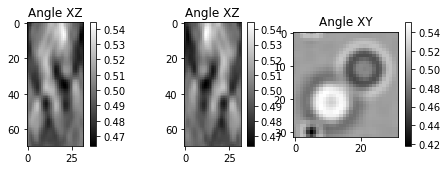

Loss@280: 12.454676 - Fid: 6.8586154, Neg: 0.095416754, TV: 5.500644 G-Phase:0.00048087683 G-ABS: 1.1039708


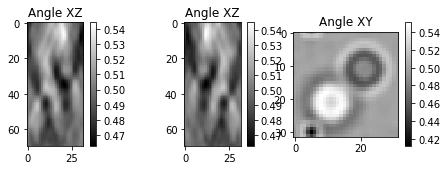

Loss@290: 6.6844063 - Fid: 1.1254995, Neg: 0.083617344, TV: 5.4752893 G-Phase:0.000467842 G-ABS: 1.1036887


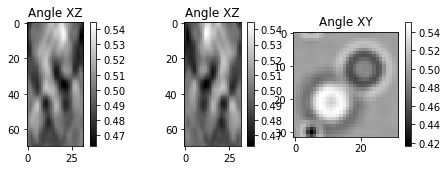

Loss@300: 6.7409725 - Fid: 1.212728, Neg: 0.07730306, TV: 5.4509416 G-Phase:0.00045534247 G-ABS: 1.1031301


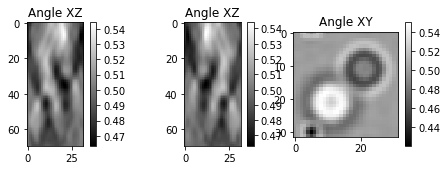

Loss@310: 6.6098514 - Fid: 1.0943851, Neg: 0.07513104, TV: 5.4403353 G-Phase:0.0004396342 G-ABS: 1.1023893


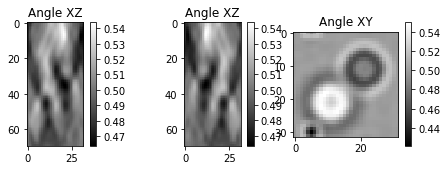

Loss@320: 6.3799095 - Fid: 0.87378573, Neg: 0.07309343, TV: 5.4330306 G-Phase:0.00042201296 G-ABS: 1.1015081


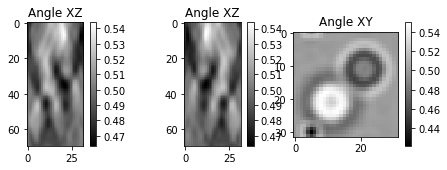

Loss@330: 6.243974 - Fid: 0.7453108, Neg: 0.071088776, TV: 5.4275746 G-Phase:0.00040286744 G-ABS: 1.1005683


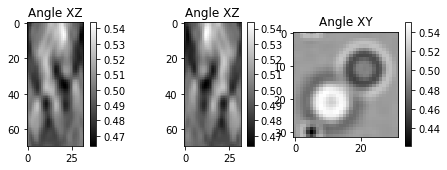

Loss@340: 6.2376423 - Fid: 0.7457839, Neg: 0.069020286, TV: 5.422838 G-Phase:0.00038253813 G-ABS: 1.0996082


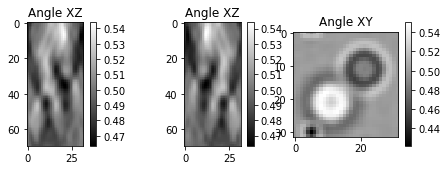

Loss@350: 6.200013 - Fid: 0.71924424, Neg: 0.06588264, TV: 5.4148865 G-Phase:0.0003618508 G-ABS: 1.0985947


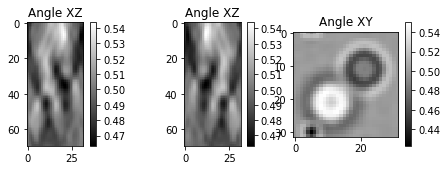

Loss@360: 6.1793575 - Fid: 0.70505357, Neg: 0.06362879, TV: 5.410675 G-Phase:0.00034102265 G-ABS: 1.0975982


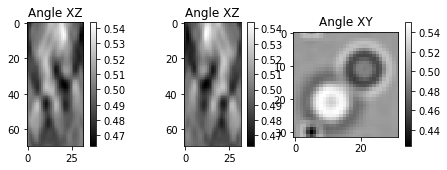

Loss@370: 6.191337 - Fid: 0.723827, Neg: 0.061236143, TV: 5.406274 G-Phase:0.0003201497 G-ABS: 1.096595


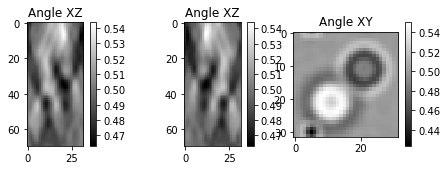

Loss@380: 12.0825615 - Fid: 6.597889, Neg: 0.063782424, TV: 5.42089 G-Phase:0.00030050517 G-ABS: 1.0958617


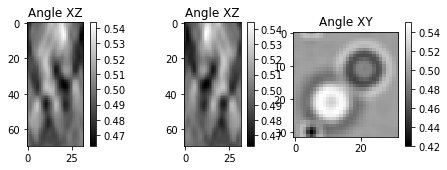

Loss@390: 19.023676 - Fid: 13.577883, Neg: 0.049462747, TV: 5.3963304 G-Phase:0.00030748892 G-ABS: 1.0959811


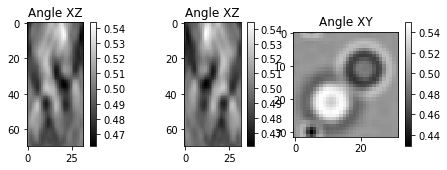

Loss@400: 10.565956 - Fid: 5.098366, Neg: 0.04585961, TV: 5.42173 G-Phase:0.00030165317 G-ABS: 1.0967153


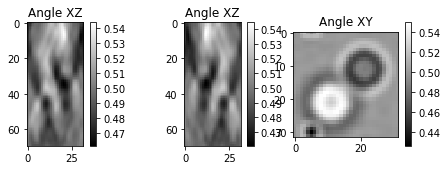

Loss@410: 7.453303 - Fid: 1.9914637, Neg: 0.04429398, TV: 5.4175453 G-Phase:0.00028823255 G-ABS: 1.0966502


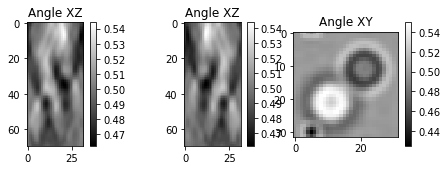

Loss@420: 6.7443824 - Fid: 1.293827, Neg: 0.043468393, TV: 5.407087 G-Phase:0.00027354993 G-ABS: 1.0960823


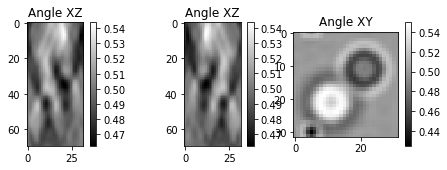

Loss@430: 6.3359528 - Fid: 0.8932253, Neg: 0.042862028, TV: 5.399865 G-Phase:0.0002547047 G-ABS: 1.0952877


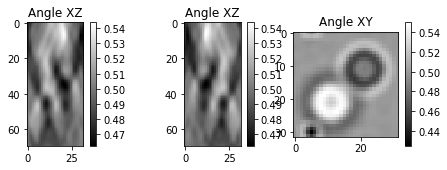

Loss@440: 6.1118593 - Fid: 0.67224944, Neg: 0.042559758, TV: 5.39705 G-Phase:0.00023338293 G-ABS: 1.0944331


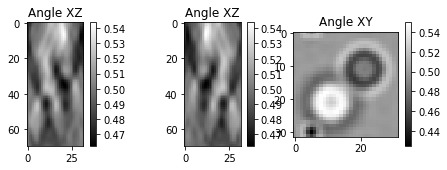

Loss@450: 6.078808 - Fid: 0.6468911, Neg: 0.04132658, TV: 5.39059 G-Phase:0.00020991164 G-ABS: 1.0934992


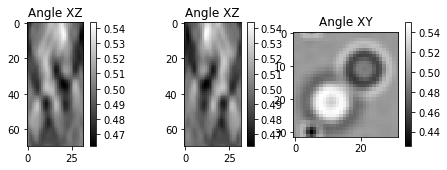

Loss@460: 6.0551662 - Fid: 0.63056576, Neg: 0.039984066, TV: 5.3846164 G-Phase:0.00018607728 G-ABS: 1.092514


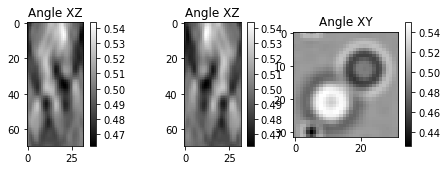

Loss@470: 6.0625396 - Fid: 0.6450768, Neg: 0.038546316, TV: 5.3789163 G-Phase:0.00016223914 G-ABS: 1.091527


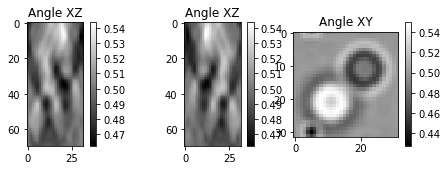

Loss@480: 6.265523 - Fid: 0.85651624, Neg: 0.036825642, TV: 5.372181 G-Phase:0.00013851514 G-ABS: 1.0905116


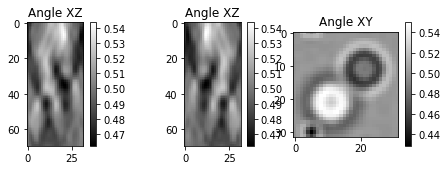

Loss@490: 28.75991 - Fid: 23.380575, Neg: 0.032093808, TV: 5.3472414 G-Phase:0.0001208634 G-ABS: 1.0894772


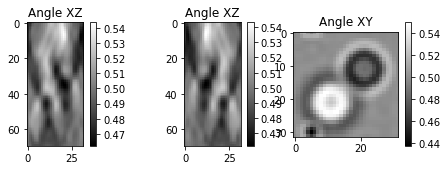

Loss@500: 6.6818566 - Fid: 1.2297089, Neg: 0.03333312, TV: 5.4188147 G-Phase:0.00013592867 G-ABS: 1.0909967


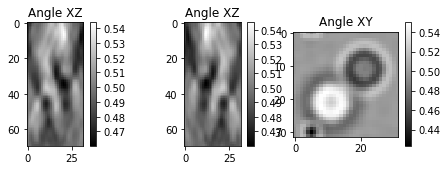

Loss@510: 6.6938953 - Fid: 1.2427821, Neg: 0.030285854, TV: 5.4208274 G-Phase:0.00012177627 G-ABS: 1.0914811


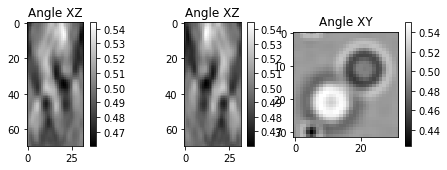

Loss@520: 6.9347816 - Fid: 1.4993851, Neg: 0.029337607, TV: 5.406059 G-Phase:0.00010787047 G-ABS: 1.0912979


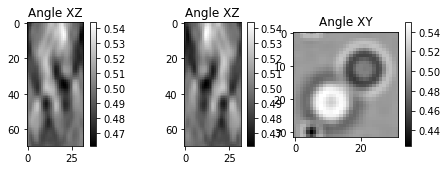

Loss@530: 6.4661703 - Fid: 1.0461146, Neg: 0.028582577, TV: 5.3914733 G-Phase:8.961228e-05 G-ABS: 1.0907067


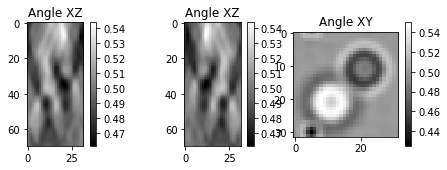

Loss@540: 6.092222 - Fid: 0.68989587, Neg: 0.026991274, TV: 5.375335 G-Phase:6.74895e-05 G-ABS: 1.0898389


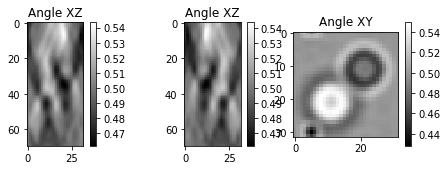

Loss@550: 5.984828 - Fid: 0.58679694, Neg: 0.026777182, TV: 5.371254 G-Phase:4.2297805e-05 G-ABS: 1.0889608


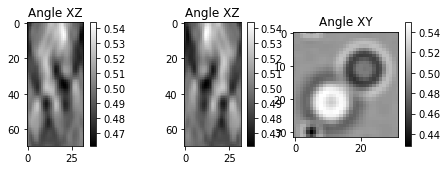

Loss@560: 5.9768534 - Fid: 0.5854633, Neg: 0.026122572, TV: 5.3652673 G-Phase:1.6103015e-05 G-ABS: 1.0880431


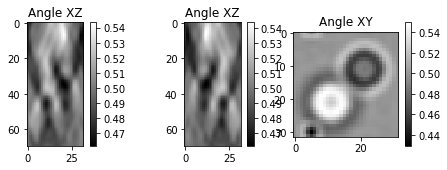

Loss@570: 5.9934897 - Fid: 0.6048406, Neg: 0.025788939, TV: 5.36286 G-Phase:-9.898431e-06 G-ABS: 1.0871288


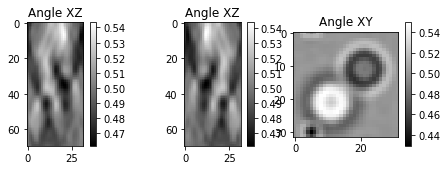

Loss@580: 6.375071 - Fid: 0.98742616, Neg: 0.025551062, TV: 5.362094 G-Phase:-3.552605e-05 G-ABS: 1.0862443


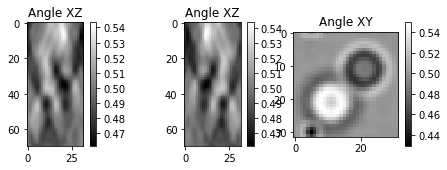

Loss@590: 31.424961 - Fid: 25.99273, Neg: 0.030586902, TV: 5.401645 G-Phase:-5.088678e-05 G-ABS: 1.0861151


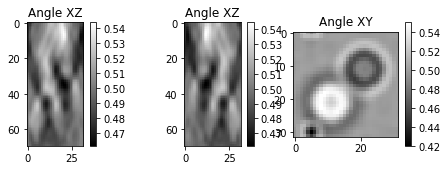

Loss@600: 8.423887 - Fid: 3.0175366, Neg: 0.020983199, TV: 5.385368 G-Phase:-4.0869803e-05 G-ABS: 1.0868124


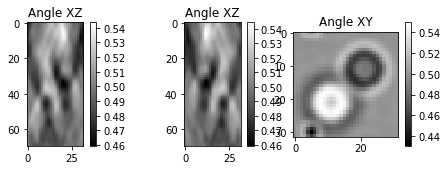

Loss@610: 8.947556 - Fid: 3.546414, Neg: 0.018800816, TV: 5.3823404 G-Phase:-5.7582747e-05 G-ABS: 1.0870646


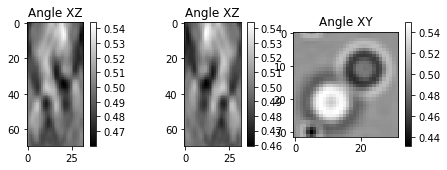

Loss@620: 6.3141217 - Fid: 0.9212736, Neg: 0.018639805, TV: 5.3742085 G-Phase:-7.177094e-05 G-ABS: 1.0868341


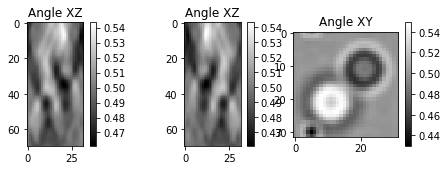

Loss@630: 6.449492 - Fid: 1.0576688, Neg: 0.019349491, TV: 5.3724737 G-Phase:-9.151427e-05 G-ABS: 1.0863566


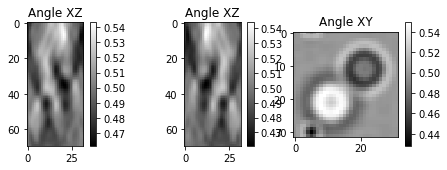

Loss@640: 6.0509415 - Fid: 0.67587733, Neg: 0.01822212, TV: 5.356842 G-Phase:-0.000115610004 G-ABS: 1.0855138


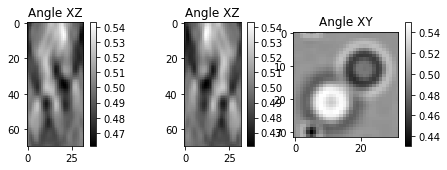

Loss@650: 6.0092044 - Fid: 0.6350589, Neg: 0.018467281, TV: 5.355678 G-Phase:-0.00014274805 G-ABS: 1.0847032


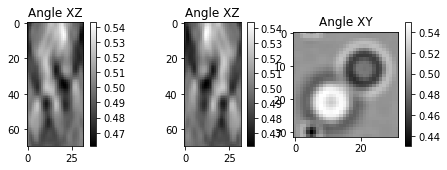

Loss@660: 5.91396 - Fid: 0.5479498, Neg: 0.01787872, TV: 5.3481317 G-Phase:-0.00017040578 G-ABS: 1.0837792


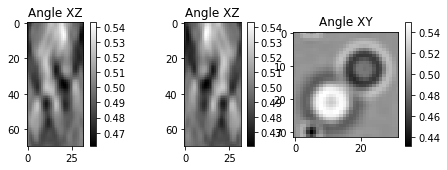

Loss@670: 6.20107 - Fid: 0.8422779, Neg: 0.017260643, TV: 5.3415313 G-Phase:-0.00019787466 G-ABS: 1.0828389


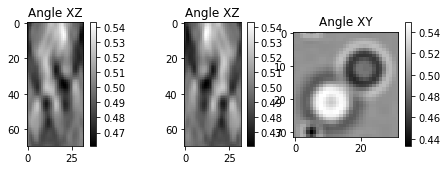

Loss@680: 22.050505 - Fid: 16.711403, Neg: 0.015673669, TV: 5.323427 G-Phase:-0.00021975851 G-ABS: 1.0818659


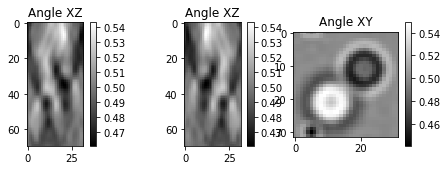

Loss@690: 16.21994 - Fid: 10.790081, Neg: 0.0179414, TV: 5.4119167 G-Phase:-0.00020439462 G-ABS: 1.0836611


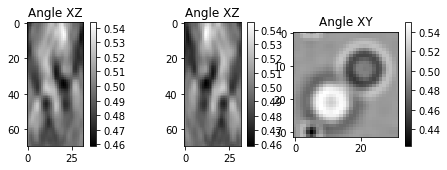

Loss@700: 7.719504 - Fid: 2.3076286, Neg: 0.01469985, TV: 5.3971753 G-Phase:-0.00021975774 G-ABS: 1.0841596


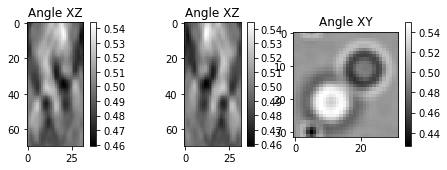

Loss@710: 6.400802 - Fid: 1.022748, Neg: 0.013114363, TV: 5.3649397 G-Phase:-0.00023339318 G-ABS: 1.0838528


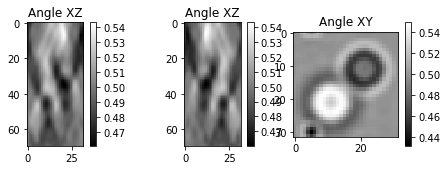

Loss@720: 6.033689 - Fid: 0.6654041, Neg: 0.013160007, TV: 5.355125 G-Phase:-0.0002539042 G-ABS: 1.0832813


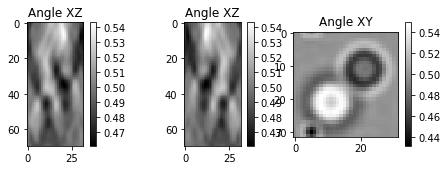

Loss@730: 6.0378957 - Fid: 0.6727925, Neg: 0.013379537, TV: 5.3517237 G-Phase:-0.0002786025 G-ABS: 1.0826441


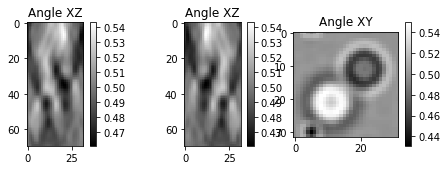

Loss@740: 5.886781 - Fid: 0.53147304, Neg: 0.013008118, TV: 5.3423 G-Phase:-0.00030737053 G-ABS: 1.0817739


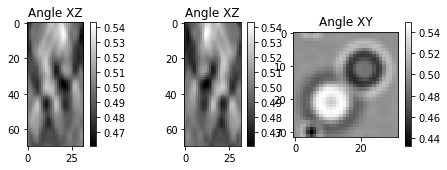

Loss@750: 5.9442906 - Fid: 0.5944433, Neg: 0.0128470035, TV: 5.3370004 G-Phase:-0.00033629977 G-ABS: 1.0809168


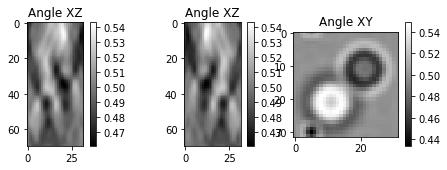

Loss@760: 6.1072187 - Fid: 0.7625596, Neg: 0.012565896, TV: 5.3320932 G-Phase:-0.00036489565 G-ABS: 1.0800362


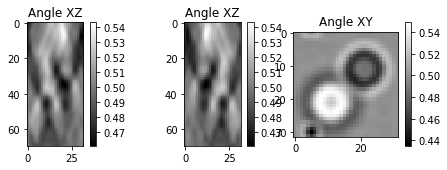

Loss@770: 17.794998 - Fid: 12.467004, Neg: 0.011614442, TV: 5.316379 G-Phase:-0.00038934354 G-ABS: 1.0790625


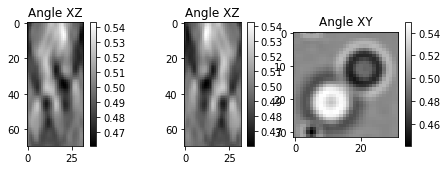

Loss@780: 16.024117 - Fid: 10.607285, Neg: 0.013399871, TV: 5.403432 G-Phase:-0.00037154532 G-ABS: 1.0808916


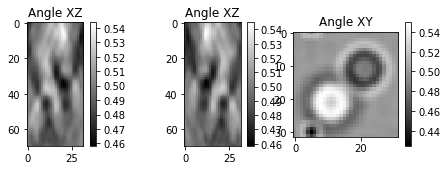

Loss@790: 5.9737167 - Fid: 0.57901156, Neg: 0.010235328, TV: 5.38447 G-Phase:-0.00038481527 G-ABS: 1.081443


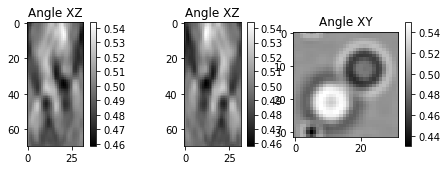

Loss@800: 7.432867 - Fid: 2.0677202, Neg: 0.009358462, TV: 5.355788 G-Phase:-0.00039777375 G-ABS: 1.0812207


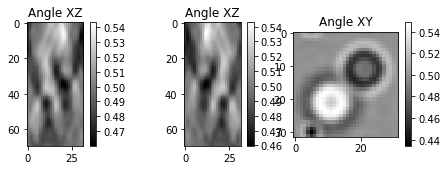

Loss@810: 5.9204535 - Fid: 0.55858266, Neg: 0.009767085, TV: 5.3521037 G-Phase:-0.00041779593 G-ABS: 1.0808342


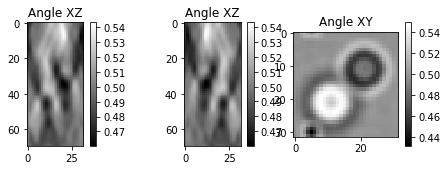

Loss@820: 5.8418546 - Fid: 0.49076846, Neg: 0.0095887, TV: 5.3414974 G-Phase:-0.00044338484 G-ABS: 1.0801742


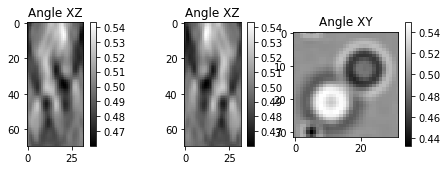

Loss@830: 5.8507013 - Fid: 0.5046398, Neg: 0.009676194, TV: 5.3363853 G-Phase:-0.00047324423 G-ABS: 1.0793885


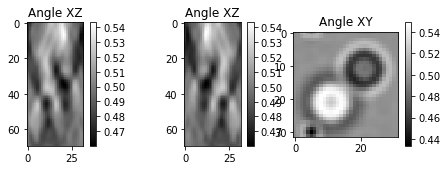

Loss@840: 5.9158673 - Fid: 0.577153, Neg: 0.009508248, TV: 5.329206 G-Phase:-0.0005033573 G-ABS: 1.078533


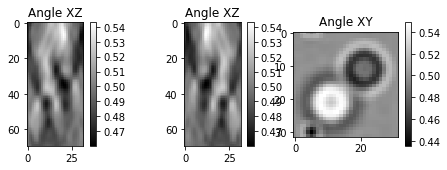

Loss@850: 6.240749 - Fid: 0.9076389, Neg: 0.009313861, TV: 5.3237963 G-Phase:-0.000532954 G-ABS: 1.077675


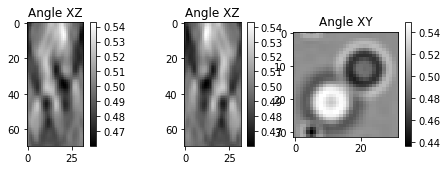

Loss@860: 18.162315 - Fid: 12.84345, Neg: 0.008805659, TV: 5.310061 G-Phase:-0.0005565119 G-ABS: 1.0768074


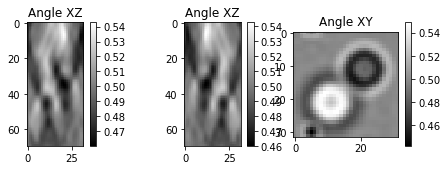

Loss@870: 12.825098 - Fid: 7.4300265, Neg: 0.0097857155, TV: 5.385286 G-Phase:-0.0005428447 G-ABS: 1.0784323


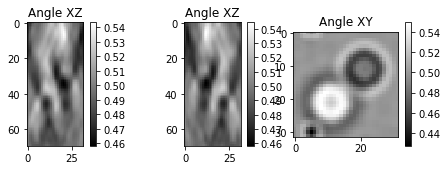

Loss@880: 7.1121 - Fid: 1.746436, Neg: 0.0075049815, TV: 5.358159 G-Phase:-0.00055841956 G-ABS: 1.0786781


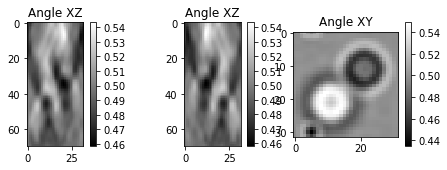

Loss@890: 6.0121765 - Fid: 0.65871584, Neg: 0.0072938493, TV: 5.346167 G-Phase:-0.0005725948 G-ABS: 1.0784965


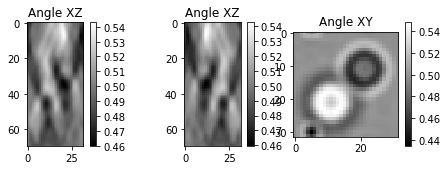

Loss@900: 6.0363812 - Fid: 0.68765783, Neg: 0.0075462842, TV: 5.341177 G-Phase:-0.0005943446 G-ABS: 1.0781152


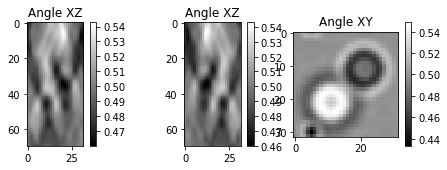

Loss@910: 5.802156 - Fid: 0.46438122, Neg: 0.007335536, TV: 5.330439 G-Phase:-0.0006213273 G-ABS: 1.0773748


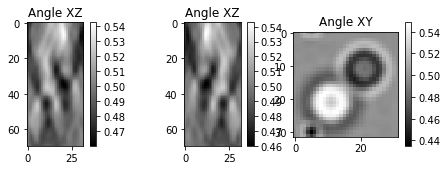

Loss@920: 6.0399466 - Fid: 0.70980847, Neg: 0.007277225, TV: 5.3228607 G-Phase:-0.00065156777 G-ABS: 1.0765859


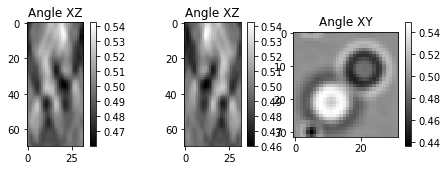

Loss@930: 6.4920707 - Fid: 1.1672716, Neg: 0.007216894, TV: 5.317582 G-Phase:-0.0006810143 G-ABS: 1.0757849


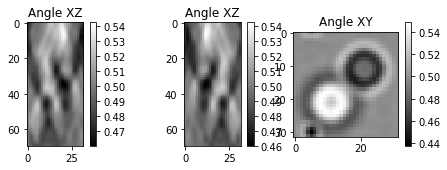

Loss@940: 19.224167 - Fid: 13.911319, Neg: 0.007021809, TV: 5.3058257 G-Phase:-0.0007021735 G-ABS: 1.0750597


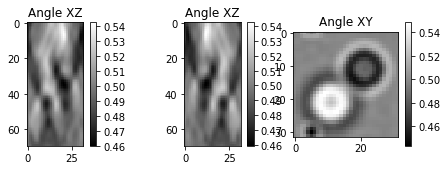

Loss@950: 11.699486 - Fid: 6.3180304, Neg: 0.0075351875, TV: 5.37392 G-Phase:-0.0006927071 G-ABS: 1.0765349


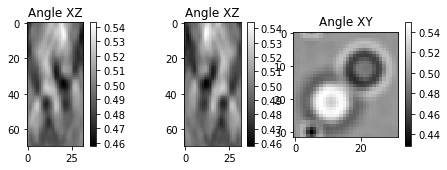

Loss@960: 8.056916 - Fid: 2.7081308, Neg: 0.0059182527, TV: 5.3428674 G-Phase:-0.00070973113 G-ABS: 1.0765567


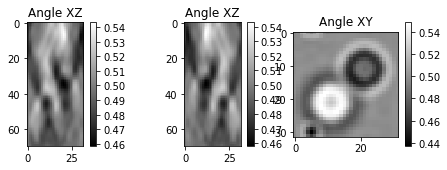

Loss@970: 6.341153 - Fid: 0.99226725, Neg: 0.006074942, TV: 5.342811 G-Phase:-0.00072467263 G-ABS: 1.0764573


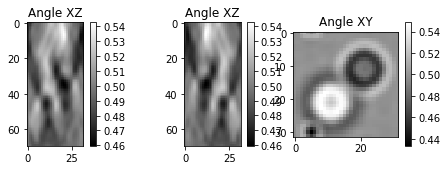

Loss@980: 6.312166 - Fid: 0.9812618, Neg: 0.005793274, TV: 5.3251114 G-Phase:-0.0007485579 G-ABS: 1.0758395


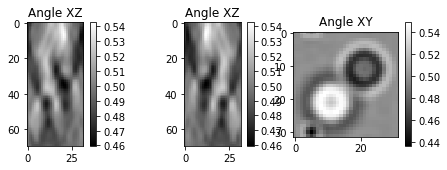

Loss@990: 5.9095163 - Fid: 0.5782924, Neg: 0.005997461, TV: 5.3252263 G-Phase:-0.00077607785 G-ABS: 1.0752546


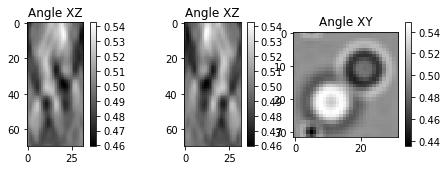

In [10]:
#%%
''' Optimize the model '''
print('Start optimizing')
np_meas = matlab_val # use the previously simulated data

for iterx in range(iter_last,Niter):
    if iterx == 1000:
        my_learningrate = my_learningrate*.1
    # try to optimize
    
    if(iterx==0 or not np.mod(iterx, Ndisplay)):
        my_opt, my_res_phase, my_loss, my_fidelity, my_negloss, my_tvloss, myglobalphase, myglobalabs, myfwd =  \
            sess.run([tf_lossop, muscat.TF_obj_phase, tf_loss, tf_fidelity, tf_negsqrloss, tf_tvloss, tf_globalphase, tf_globalabs, tf_fwd], \
                     feed_dict={tf_meas:np_meas, tf_learningrate:my_learningrate})

        print('Loss@'+str(iterx)+': ' + str(my_loss) + ' - Fid: '+str(my_fidelity)+', Neg: '+str(my_negloss)+', TV: '+str(my_tvloss)+' G-Phase:'+str(myglobalphase)+' G-ABS: '+str(myglobalabs))        
        mylosslist.append(my_loss)
        myfidelitylist.append(my_fidelity)
        myneglosslist.append(my_negloss)
        mytvlosslist.append(my_tvloss)
        result_phaselist.append(my_res_phase)
        globalphaselist.append(myglobalphase)
        globalabslist.append(myglobalabs)  
        
        if(is_display): plt.subplot(234), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
        if(is_display): plt.subplot(235), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
        if(is_display): plt.subplot(236), plt.title('Angle XY'),plt.imshow(np.angle(myfwd)[myfwd.shape[0]//2,:,:]), plt.colorbar(), plt.show()

    else:
        sess.run([tf_lossop], feed_dict={tf_meas:np_meas, tf_learningrate:my_learningrate})
        #plt.imshow(np.abs(my_res[:,50,:]))
        

#save stack to disk
#sktiff.imsave(savepath+'Obj_Reconstruction.tif', np.array(resultlist), compress=6, metadata={'axes': 'TZXY'})

# Display result - FFT

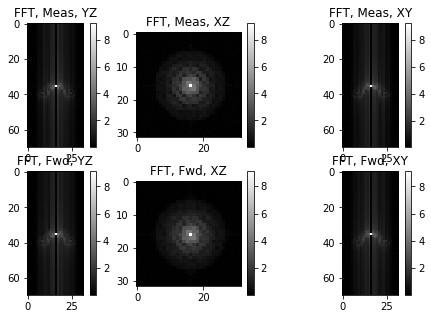

In [11]:
iter_last = iterx
#%% Display the results
is_display=True
myfwd, mymeas, my_res_phase = sess.run([tf_fwd, tf_meas, muscat.TF_obj_phase], feed_dict={tf_meas:np_meas})
        
if(is_display): plt.subplot(231),plt.title('FFT, Meas, YZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[:,mymeas.shape[1]//2,:]), plt.colorbar()#, plt.show()    
if(is_display): plt.subplot(232),plt.title('FFT, Meas, XZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[mymeas.shape[0]//2,:,:]), plt.colorbar()#, plt.show()   
if(is_display): plt.subplot(233),plt.title('FFT, Meas, XY'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[:,:,mymeas.shape[2]//2]), plt.colorbar()#, plt.show()     
if(is_display): plt.subplot(234),plt.title('FFT, Fwd, YZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235),plt.title('FFT, Fwd, XZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[myfwd.shape[0]//2,:,:]), plt.colorbar()#, plt.show()    
if(is_display): plt.subplot(236),plt.title('FFT, Fwd, XY'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[:,:,myfwd.shape[2]//2]), plt.colorbar(), plt.show()    


In [12]:
#%%
''' Optimize the model '''
print('Start optimizing')
np_meas = matlab_val # use the previously simulated data

for iterx in range(iter_last,Niter):
    if iterx == 1000:
        my_learningrate = my_learningrate*.1
    # try to optimize
    
    if(iterx==0 or not np.mod(iterx, Ndisplay)):
        my_opt, my_res_phase, my_loss, my_fidelity, my_negloss, my_tvloss, myglobalphase, myglobalabs, myfwd =  \
            sess.run([tf_lossop, muscat.TF_obj_phase, tf_loss, tf_fidelity, tf_negsqrloss, tf_tvloss, tf_globalphase, tf_globalabs, tf_fwd], \
                     feed_dict={tf_meas:np_meas, tf_learningrate:my_learningrate})

        print('Loss@'+str(iterx)+': ' + str(my_loss) + ' - Fid: '+str(my_fidelity)+', Neg: '+str(my_negloss)+', TV: '+str(my_tvloss)+' G-Phase:'+str(myglobalphase)+' G-ABS: '+str(myglobalabs))        
        mylosslist.append(my_loss)
        myfidelitylist.append(my_fidelity)
        myneglosslist.append(my_negloss)
        mytvlosslist.append(my_tvloss)
        result_phaselist.append(my_res_phase)
        globalphaselist.append(myglobalphase)
        globalabslist.append(myglobalabs)  
        if(False):
            if(is_display): plt.subplot(234), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
            if(is_display): plt.subplot(235), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
            if(is_display): plt.subplot(236), plt.title('Angle XY'),plt.imshow(np.angle(myfwd)[myfwd.shape[0]//2,:,:]), plt.colorbar(), plt.show()

    else:
        sess.run([tf_lossop], feed_dict={tf_meas:np_meas, tf_learningrate:my_learningrate})
        #plt.imshow(np.abs(my_res[:,50,:]))
        

#save stack to disk
#sktiff.imsave(savepath+'Obj_Reconstruction.tif', np.array(resultlist), compress=6, metadata={'axes': 'TZXY'})

Start optimizing


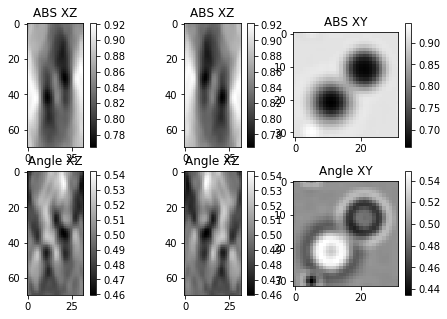

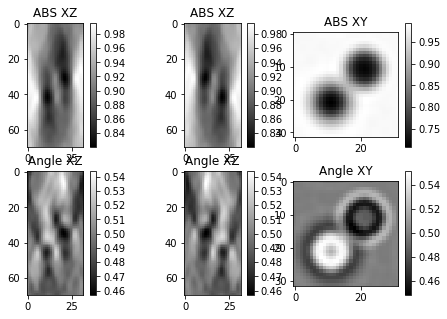

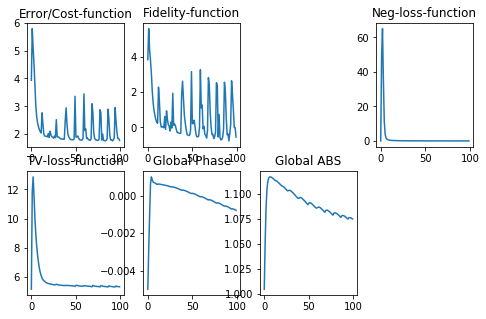

(<matplotlib.axes._subplots.AxesSubplot at 0x26828c3b828>,
 Text(0.5,1,'Global ABS'),
 None)

In [13]:
# This is the reconstruction
if(is_display): plt.subplot(231), plt.title('ABS XZ'),plt.imshow(np.abs(myfwd)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(232), plt.title('ABS XZ'),plt.imshow(np.abs(myfwd)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(233), plt.title('ABS XY'),plt.imshow(np.abs(myfwd)[myfwd.shape[0]//2,:,:]), plt.colorbar()#, plt.show()

if(is_display): plt.subplot(234), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(236), plt.title('Angle XY'),plt.imshow(np.angle(myfwd)[myfwd.shape[0]//2,:,:]), plt.colorbar(), plt.show()

# This is the measurment
if(is_display): plt.subplot(231), plt.title('ABS XZ'),plt.imshow(np.abs(np_meas)[:,np_meas.shape[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(232), plt.title('ABS XZ'),plt.imshow(np.abs(np_meas)[:,:,np_meas.shape[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(233), plt.title('ABS XY'),plt.imshow(np.abs(np_meas)[np_meas.shape[0]//2,:,:]), plt.colorbar()#, plt.show()

if(is_display): plt.subplot(234), plt.title('Angle XZ'),plt.imshow(np.angle(np_meas)[:,np_meas.shape[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235), plt.title('Angle XZ'),plt.imshow(np.angle(np_meas)[:,:,np_meas.shape[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(236), plt.title('Angle XY'),plt.imshow(np.angle(np_meas)[np_meas.shape[0]//2,:,:]), plt.colorbar(), plt.show()

# diplay the error over time
plt.subplot(241), plt.title('Error/Cost-function'), plt.plot(np.log(np.array(mylosslist)))#, plt.show()
plt.subplot(242), plt.title('Fidelity-function'), plt.plot(np.log(np.array(myfidelitylist)))#, plt.show()
#plt.subplot(243), plt.title('Pos-loss-function'), plt.plot(np.array(myposlosslist))#, plt.show()
plt.subplot(244), plt.title('Neg-loss-function'), plt.plot(np.array(myneglosslist))#, plt.show()
plt.subplot(245), plt.title('TV-loss-function'), plt.plot(np.array(mytvlosslist))#, plt.show()
plt.subplot(246), plt.title('Global Phase'), plt.plot(np.array(globalphaselist))#, plt.show()
plt.subplot(247), plt.title('Global ABS'), plt.plot(np.array(globalabslist)), plt.show()



# Display Result Refractive index

# Display results ABS/Angle - FWD model

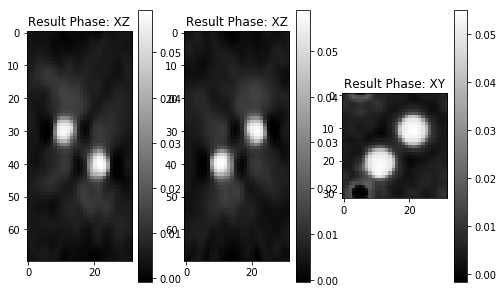

In [14]:
if(is_display): plt.subplot(131), plt.title('Result Phase: XZ'),plt.imshow(my_res_phase[:,my_res_phase.shape[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(132), plt.title('Result Phase: XZ'),plt.imshow(my_res_phase[:,:,my_res_phase.shape[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(133), plt.title('Result Phase: XY'),plt.imshow(my_res_phase[my_res_phase.shape[0]//2,:,:]), plt.colorbar(), plt.show()


[0. 0. 0. 0. 0. 0. 0. 0. 0.]


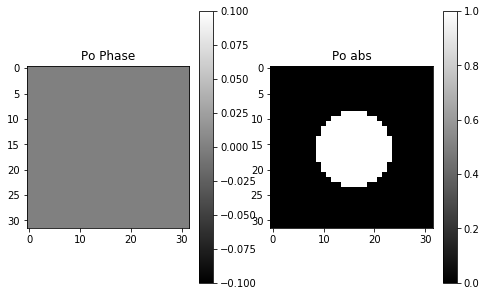

Assuming first axis is time


In [15]:
#plt.subplot(121), plt.imshow(np.angle(sess.run(muscat.TF_Po.eval)))
print(np.real(sess.run(muscat.TF_zernikefactors)))
plt.subplot(121), plt.title('Po Phase'), plt.imshow(np.fft.fftshift(np.angle(sess.run(muscat.TF_Po_aberr)))), plt.colorbar()
plt.subplot(122), plt.title('Po abs'), plt.imshow(np.fft.fftshift(np.abs(sess.run(muscat.TF_Po_aberr)))), plt.colorbar(), plt.show()

#np.save(savepath+'/myrefractiveindex.npy',np.array(resultlist))
data.export_realdatastack_h5(savepath+'/myrefractiveindex.h5', 'temp', np.array(result_phaselist))

# Display recovered pupil

# Save results

# %% save the results
np.save(savepath+'/rec.npy', my_res)
data.saveHDF5(my_res, savepath+'/Obj_Reconstruction.h5')
data.saveHDF5(np.abs(np_meas), savepath+'/Amplitude_abs.h5')
data.saveHDF5(np.angle(np_meas), savepath+'/Amplitude_angle.h5')